## Prepare Dataset

In [8]:
from pathlib import Path

from sklearn.preprocessing import MinMaxScaler
from torchvision.transforms import Compose
import numpy as np
from matplotlib import pyplot as plt
plt.rcParams['figure.figsize'] = [14, 8]

from dataset import BeatboxDataset
import transforms as tf
from constants import *

In [2]:
# Use MFCC instead of Mel Spectrogram for non deep learning
mfcc_transforms = Compose([
    tf.MelSpectrogram(SAMPLE_RATE, n_fft=2048, hop_length=512, n_mels=128),
    tf.MFCC(np.mean)
])
root_path = Path("/home/martin/school/4B/MSCI_446/AVP_Dataset/processed_dataset")
train_set = BeatboxDataset(root_path, "train", CLASS_MAP, mfcc_transforms)
val_set = BeatboxDataset(root_path, "val", CLASS_MAP, mfcc_transforms)

In [3]:
# Collect all examples into single numpy arrays to use with sklearn
train_X = []
train_y = []
for sample in train_set:
    train_X.append(sample[0])
    train_y.append(sample[1])
    
train_X = np.vstack(train_X)
train_y = np.array(train_y)

test_X = []
test_y = []
for sample in val_set:
    test_X.append(sample[0])
    test_y.append(sample[1])
    
test_X = np.vstack(test_X)
test_y = np.array(test_y)

# Scale X features to 0-1
scaler = MinMaxScaler()
train_X = scaler.fit_transform(train_X)
test_X = scaler.transform(test_X)

/home/martin/miniconda3/envs/beatbox/lib/python3.8/site-packages/librosa/util/decorators.py:88: UserWarning: n_fft=2048 is too small for input signal of length=1401
  return f(*args, **kwargs)


## Unsupervised Learning

[0.29476097 0.11301696 0.06893691 0.06600273 0.0538997  0.04983456
 0.04199409 0.04123883 0.03873445 0.03363553 0.02819533 0.02699508
 0.02390158 0.02225349 0.02103007 0.0196693  0.01661059 0.01477583
 0.01273423 0.01177971]


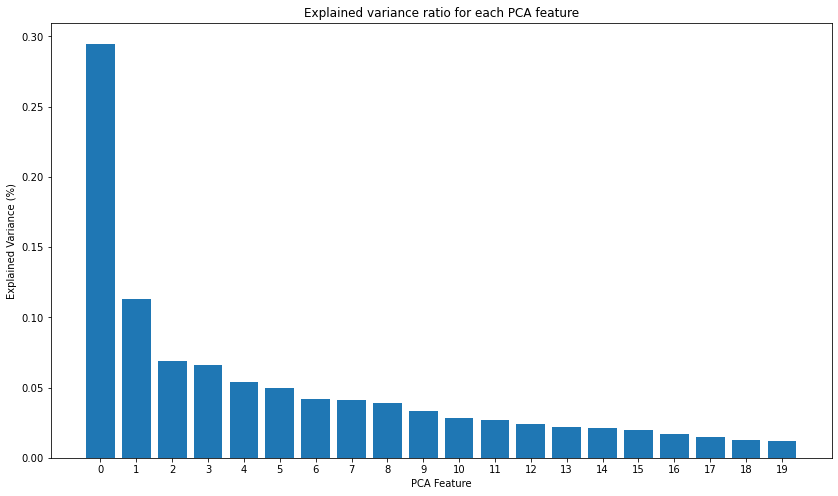

In [9]:
# Get variance of all PCA dims and plot
from sklearn.decomposition import PCA
pca = PCA()
pca.fit(train_X)
print(pca.explained_variance_ratio_)

features = range(pca.n_components_)
plt.bar(features, pca.explained_variance_ratio_)
plt.xlabel('PCA Feature')
plt.ylabel('Explained Variance (%)')
plt.xticks(features)
plt.title("Explained variance ratio for each PCA feature")
plt.show()

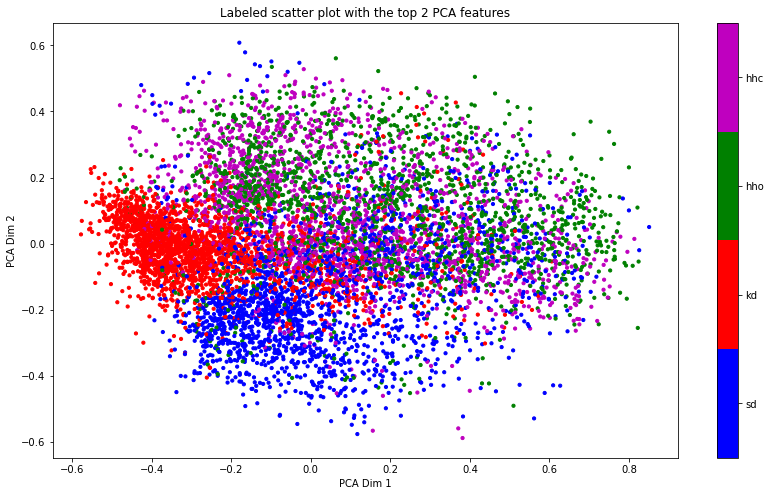

In [14]:
# 2D plot using PCA
from sklearn.decomposition import PCA
from matplotlib import colors

pca = PCA(n_components=2)
train_X_2d = pca.fit_transform(train_X)
cmap = colors.ListedColormap(['b','r','g','m'])

plt.scatter(train_X_2d[:, 0], train_X_2d[:, 1], c=train_y, s=10, cmap=cmap)
cb = plt.colorbar()
loc = np.arange(3/4/2, 3, 3/4) # 3 is max label value and 4 is num classes
cb.set_ticks(loc)
cb.set_ticklabels(CLASS_MAP)
plt.title("Labeled scatter plot with the top 2 PCA features")
plt.xlabel("PCA Dim 1")
plt.ylabel("PCA Dim 2")
plt.show()

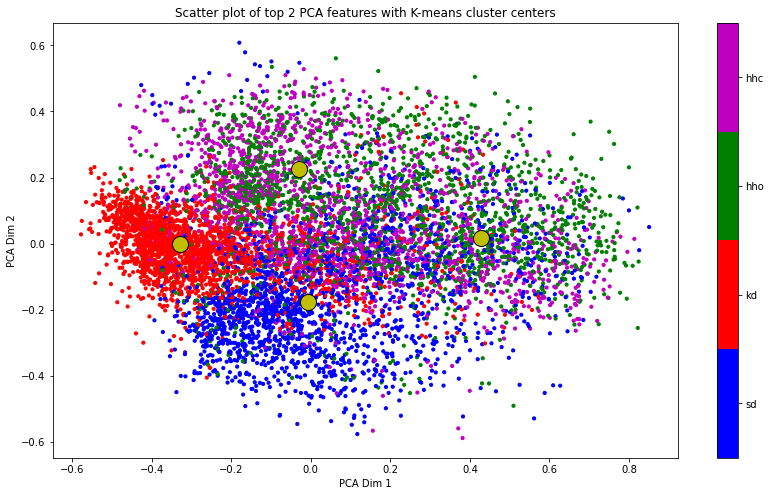

In [33]:
# K means using PCA features
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=4, random_state=0).fit(train_X_2d)
kmeans.cluster_centers_

cmap = colors.ListedColormap(['b','r','g','m'])
plt.scatter(train_X_2d[:, 0], train_X_2d[:, 1], c=train_y, s=10, cmap=cmap)
cb = plt.colorbar()
loc = np.arange(3/4/2, 3, 3/4) # 3 is max label value and 4 is num classes
cb.set_ticks(loc)
cb.set_ticklabels(CLASS_MAP)
plt.title("Scatter plot of top 2 PCA features with K-means cluster centers")
plt.xlabel("PCA Dim 1")
plt.ylabel("PCA Dim 2")
plt.plot(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], 'yo', markersize=16, markeredgecolor='k')
plt.show()


## Supervised Learning

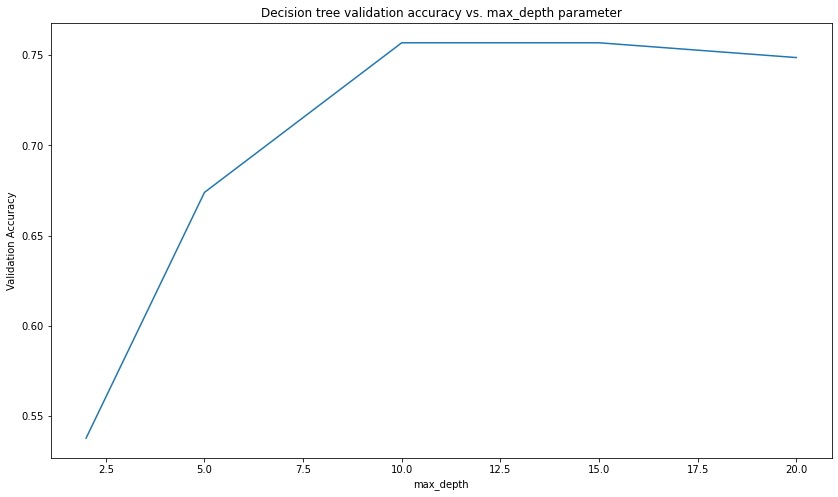

Best accuracy: 0.7569089048106449


In [66]:
# Decision tree
from sklearn.tree import DecisionTreeClassifier

params = [2, 5, 10, 15, 20]
acc = []

for p in params:
    clf = DecisionTreeClassifier(max_depth=p, random_state=0)
    clf.fit(train_X, train_y)
    acc.append(clf.score(test_X, test_y))

plt.plot(params, acc)
plt.title("Decision tree validation accuracy vs. max_depth parameter")
plt.ylabel("Validation Accuracy")
plt.xlabel("max_depth")
plt.show()
print(f"Best accuracy: {max(acc)}")

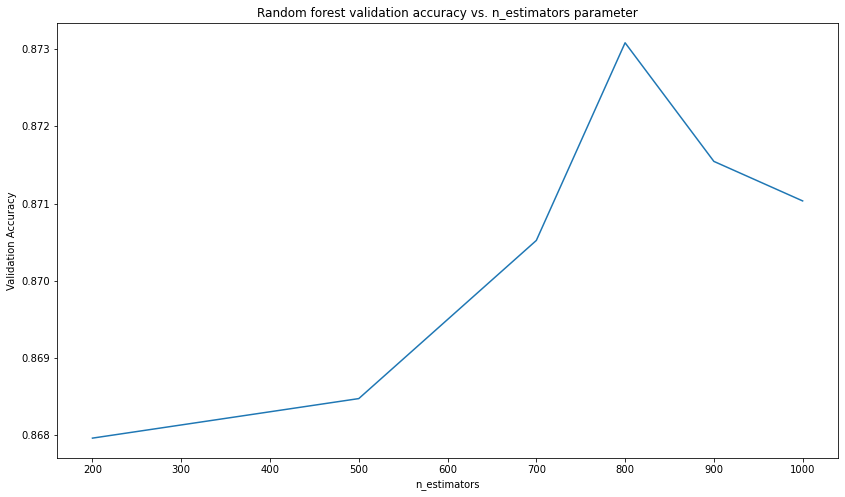

Best accuracy: 0.8730808597748209


In [47]:
# Random forest
from sklearn.ensemble import RandomForestClassifier

params = [200, 500, 700, 800, 900, 1000]
acc = []

for p in params:
    clf = RandomForestClassifier(n_estimators=p, random_state=0)
    clf.fit(train_X, train_y)
    acc.append(clf.score(test_X, test_y))

plt.plot(params, acc)
plt.title("Random forest validation accuracy vs. n_estimators parameter")
plt.ylabel("Validation Accuracy")
plt.xlabel("n_estimators")
plt.show()
print(f"Best accuracy: {max(acc)}")

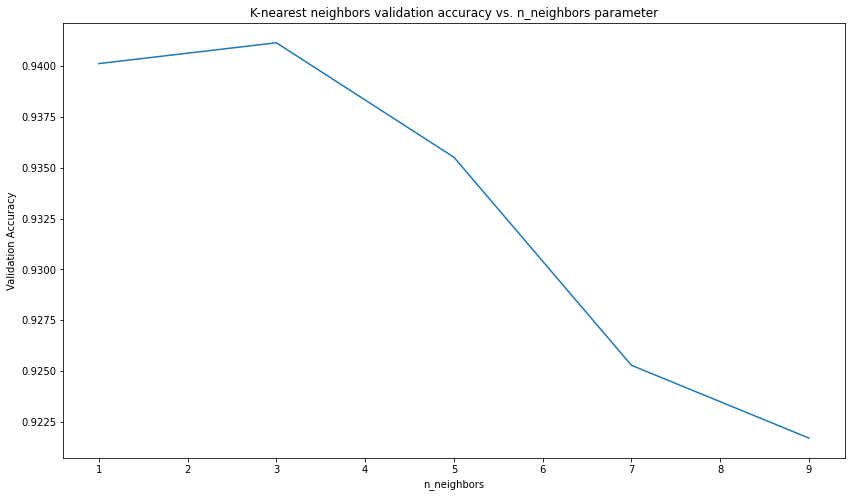

Best accuracy: 0.9411463664278403


In [75]:
# K-Nearest neighbors
from sklearn.neighbors import KNeighborsClassifier

params = [1, 3, 5, 7, 9]
acc = []

for p in params:
    clf = KNeighborsClassifier(n_neighbors=p)
    clf.fit(train_X, train_y)
    acc.append(clf.score(test_X, test_y))

plt.plot(params, acc)
plt.title("K-nearest neighbors validation accuracy vs. n_neighbors parameter")
plt.ylabel("Validation Accuracy")
plt.xlabel("n_neighbors")
plt.show()
print(f"Best accuracy: {max(acc)}")

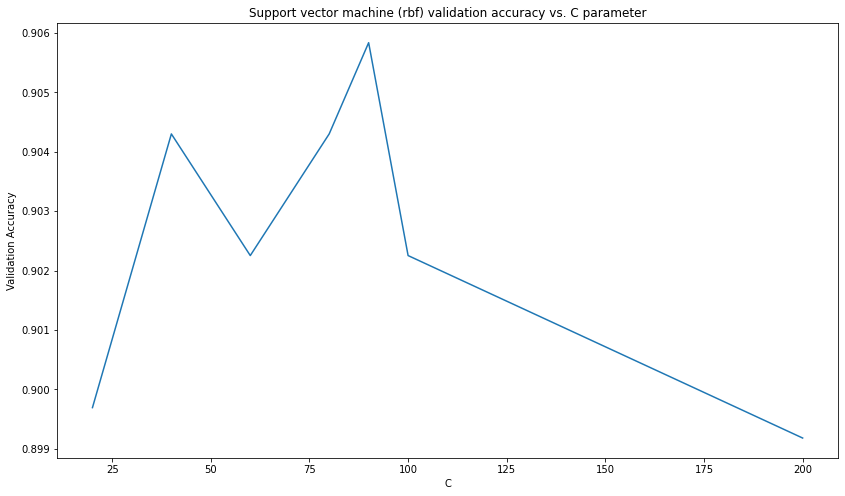

Best accuracy: 0.9058341862845445


In [80]:
# Support Vector Machine (rbf)
from sklearn.svm import SVC

params = [20.0, 40.0, 60.0, 80.0, 90.0, 100.0, 200.0]
acc = []

for p in params:
    clf = SVC(C=p, random_state=0)
    clf.fit(train_X, train_y)
    acc.append(clf.score(test_X, test_y))

plt.plot(params, acc)
plt.title("Support vector machine (rbf) validation accuracy vs. C parameter")
plt.ylabel("Validation Accuracy")
plt.xlabel("C")
plt.show()
print(f"Best accuracy: {max(acc)}")

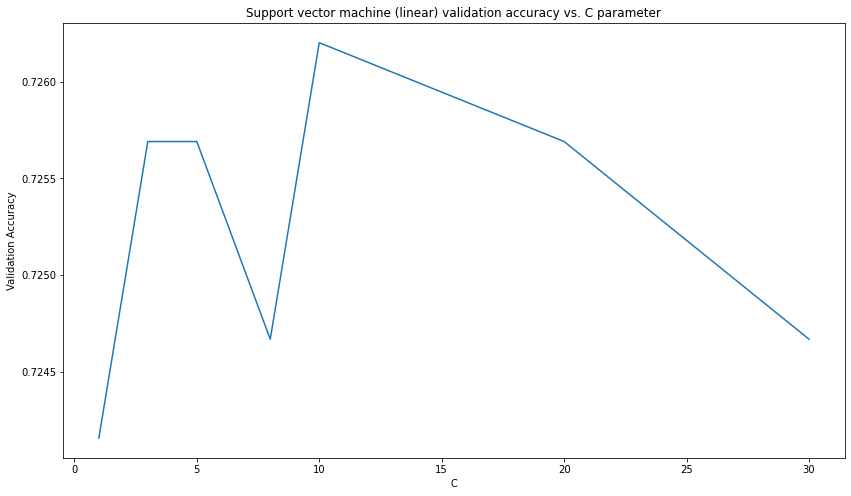

Best accuracy: 0.7262026612077789


In [79]:
# Support Vector Machine (linear)
from sklearn.svm import SVC

params = [1.0, 3.0, 5.0, 8.0, 10.0, 20.0, 30.0]
acc = []

for p in params:
    clf = SVC(C=p, kernel='linear', random_state=0)
    clf.fit(train_X, train_y)
    acc.append(clf.score(test_X, test_y))

plt.plot(params, acc)
plt.title("Support vector machine (linear) validation accuracy vs. C parameter")
plt.ylabel("Validation Accuracy")
plt.xlabel("C")
plt.show()
print(f"Best accuracy: {max(acc)}")